In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LayerNormalization
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH ="F:\\Research database\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1\\Train"
BATCH_SIZE = 2
EPOCHS = 20

In [3]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips

def get_training_set():
    clips = []
    for f in sorted(listdir(DATASET_PATH)):
        directory_path = join(DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 255.0 #normalize
                    all_frames.append(img)
            clips.extend(get_clips_by_stride(stride=1, frames_list=all_frames, sequence_size=5))
    return clips

In [ ]:
############################# convolutionLSTM Autoencoder ######################

In [4]:
training_set = get_training_set()
training_set = np.array(training_set)
model = Sequential()
### conv encoder ##
model.add(TimeDistributed(Conv2D(64, (7, 7), strides=4, padding="same"), batch_input_shape=(None, 5, 256, 256, 1)))
model.add(LayerNormalization())
model.add(TimeDistributed(Conv2D(32, (5, 5), strides=2, padding="same")))
model.add(LayerNormalization())

model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True)) #temporal encoder
model.add(LayerNormalization())
model.add(ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True)) #bottleneck
model.add(LayerNormalization())
model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True)) #temporal decoder
model.add(LayerNormalization())

## conv decoder ##
model.add(TimeDistributed(Conv2DTranspose(32, (5, 5), strides=2, padding="same")))
model.add(LayerNormalization())
model.add(TimeDistributed(Conv2DTranspose(64, (7, 7), strides=4, padding="same")))
model.add(LayerNormalization())
model.add(TimeDistributed(Conv2D(1, (7, 7), activation="sigmoid", padding="same")))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 64, 64, 64)     3200      
_________________________________________________________________
layer_normalization (LayerNo (None, 5, 64, 64, 64)     128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 32, 32, 32)     51232     
_________________________________________________________________
layer_normalization_1 (Layer (None, 5, 32, 32, 32)     64        
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 5, 32, 32, 32)     73856     
_________________________________________________________________
layer_normalization_2 (Layer (None, 5, 32, 32, 32)     64        
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 5, 32, 32, 16)     2

In [5]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), metrics=['mse'])
history = model.fit(training_set, training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=False)
model.save('model.h5')

Train on 1360 samples
Epoch 1/20
1360/1360 [==============================] - 241s 177ms/sample - loss: 0.0082 - mse: 0.0082
Epoch 2/20
1360/1360 [==============================] - 233s 171ms/sample - loss: 0.0032 - mse: 0.0032
Epoch 3/20
1360/1360 [==============================] - 233s 172ms/sample - loss: 0.0025 - mse: 0.0025
Epoch 4/20
1360/1360 [==============================] - 235s 173ms/sample - loss: 0.0021 - mse: 0.0021
Epoch 5/20
1360/1360 [==============================] - 233s 172ms/sample - loss: 0.0018 - mse: 0.0018
Epoch 6/20
1360/1360 [==============================] - 233s 172ms/sample - loss: 0.0016 - mse: 0.0016
Epoch 7/20
1360/1360 [==============================] - 233s 172ms/sample - loss: 0.0015 - mse: 0.0015
Epoch 8/20
1360/1360 [==============================] - 234s 172ms/sample - loss: 0.0014 - mse: 0.0014
Epoch 9/20
1360/1360 [==============================] - 233s 172ms/sample - loss: 0.0012 - mse: 0.0012
Epoch 10/20
1360/1360 [============================

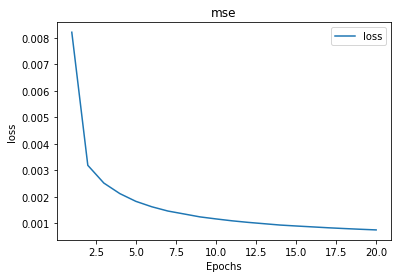

In [10]:
history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label="loss")
plt.title("mse")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig("Train_Vs_Validation_loss.jpeg")
plt.show()
